In [1]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject, CUDA, DifferentialEquations, PyPlot, NNlib,  ImageFiltering, Images, MEngProject, MEngProject.LamKernels, MEngProject.Laminart, MEngProject.Utils, BenchmarkTools, Test

┌ Info: Precompiling MEngProject [d0493a11-efc0-4c7c-9b66-d0bd5a04cc55]
└ @ Base loading.jl:1260


In [2]:
function reshape2d_4d(img::AbstractArray)
    reshape(img, size(img)[1], size(img)[2], 1, 1)
end

reshape2d_4d (generic function with 1 method)

In [86]:
img = convert(Array{Float32,2}, load(datadir("Iine_100_100_gs.png")));
img = reshape2d_4d(img)
img = cu(img)
r = similar(img)

p = LaminartGPU.kernels(img, Parameters.parameters);

LaminartGPU.I_u!(r, img, p)
temp_out = (I = img, r = r)
p = merge(p, temp_out);

In [87]:
tspan = (0.0f0, 5f0)
u0 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2,1));

In [33]:
# img = convert(Array{Float32,2}, load(datadir("Iine_100_100_gs.png")));
# img = reshape2d_4d(img)
# # img = cu(img)
# r = similar(img)

# p = LaminartGPU.kernels(img, Parameters.parameters);

# LaminartGPU.I_u!(r, img, p)
# temp_out = (I = img, r = r)
# p = merge(p, temp_out);

In [34]:
# tspan = (0.0f0, 5f0)
# u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2,1);

In [5]:
x_lgn = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1))
C = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1))
H_z = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1));
V_temp_1 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1));
V_temp_2 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1));
A_temp = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1));
B_temp = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1));

In [88]:
arr1 = u0[:, :, 1:p.K,:]
arr2 = u0[:, :, 1:1,:];

In [ ]:
f = LaminartGPU.LamFunction(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [37]:
prob= ODEProblem(f, u0, tspan, p);

In [38]:
sys = modelingtoolkitize(prob)

KeyError: KeyError: key 'K' not found

In [17]:
p.K

2

In [68]:
using Latexify
latexify(uv[1,1,1,1])

L"$uv₁ˏ₁ˏ₁ˏ₁$"

In [70]:
cuv = cu(uv)

ErrorException: CuArray only supports bits types

In [72]:
# prob.f isa DiffEqBase.AbstractParameterizedFunction &&
#                             return (prob.f.sys, prob.f.sys.states, prob.f.sys.ps)
    @parameters t
    vars = reshape([Variable(:x, i)(t) for i in eachindex(prob.u0)],size(prob.u0))
#     params = prob.p isa DiffEqBase.NullParameters ? [] :
#              reshape([Variable(:α,i)() for i in eachindex(prob.p)],size(prob.p))
    @derivatives D'~t

    rhs = [D(var) for var in vars]

    if DiffEqBase.isinplace(prob)
        lhs = similar(vars, Any)
        prob.f(lhs, vars, p, t)
    else
        lhs = prob.f(vars, p, t)
    end

    eqs = vcat([rhs[i] ~ lhs[i] for i in eachindex(prob.u0)]...)
    de = ODESystem(eqs,t,vec(vars),vec(p))

    de

MethodError: MethodError: no method matching Float32(::Operation)
Closest candidates are:
  Float32(::T) where T<:Number at boot.jl:715
  Float32(!Matched::Int8) at float.jl:60
  Float32(!Matched::Int16) at float.jl:60
  ...

In [78]:
DiffEqBase.isinplace(prob)

true

In [75]:
prob.p.K

2

In [79]:
prob.f(lhs, vars, p, t)

MethodError: MethodError: no method matching Float32(::Operation)
Closest candidates are:
  Float32(::T) where T<:Number at boot.jl:715
  Float32(!Matched::Int8) at float.jl:60
  Float32(!Matched::Int16) at float.jl:60
  ...

In [82]:
@. f.x = @view vars[:, :, 1:p.K,:]

GPUCompiler.KernelError: GPU compilation of kernel broadcast(CUDA.CuKernelContext, CuDeviceArray{Float32,4,CUDA.AS.Global}, Base.Broadcast.Broadcasted{Nothing,NTuple{4,Base.OneTo{Int64}},typeof(identity),Tuple{Base.Broadcast.Extruded{SubArray{Operation,4,Array{Operation,4},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},NTuple{4,Bool},NTuple{4,Int64}}}}) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{Nothing,NTuple{4,Base.OneTo{Int64}},typeof(identity),Tuple{Base.Broadcast.Extruded{SubArray{Operation,4,Array{Operation,4},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},NTuple{4,Bool},NTuple{4,Int64}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Extruded{SubArray{Operation,4,Array{Operation,4},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},NTuple{4,Bool},NTuple{4,Int64}}} which is not isbits.
    .1 is of type Base.Broadcast.Extruded{SubArray{Operation,4,Array{Operation,4},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},NTuple{4,Bool},NTuple{4,Int64}} which is not isbits.
      .x is of type SubArray{Operation,4,Array{Operation,4},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false} which is not isbits.
        .parent is of type Array{Operation,4} which is not isbits.

Passing non-isbits types is only allowed if they they are unused by the kernel.


In [76]:
vars

100×100×12×1 Array{Operation,4}:
[:, :, 1, 1] =
   x₁(t)  x₁₀₁(t)  x₂₀₁(t)  x₃₀₁(t)  …  x₉₇₀₁(t)  x₉₈₀₁(t)   x₉₉₀₁(t)
   x₂(t)  x₁₀₂(t)  x₂₀₂(t)  x₃₀₂(t)     x₉₇₀₂(t)  x₉₈₀₂(t)   x₉₉₀₂(t)
   x₃(t)  x₁₀₃(t)  x₂₀₃(t)  x₃₀₃(t)     x₉₇₀₃(t)  x₉₈₀₃(t)   x₉₉₀₃(t)
   x₄(t)  x₁₀₄(t)  x₂₀₄(t)  x₃₀₄(t)     x₉₇₀₄(t)  x₉₈₀₄(t)   x₉₉₀₄(t)
   x₅(t)  x₁₀₅(t)  x₂₀₅(t)  x₃₀₅(t)     x₉₇₀₅(t)  x₉₈₀₅(t)   x₉₉₀₅(t)
   x₆(t)  x₁₀₆(t)  x₂₀₆(t)  x₃₀₆(t)  …  x₉₇₀₆(t)  x₉₈₀₆(t)   x₉₉₀₆(t)
   x₇(t)  x₁₀₇(t)  x₂₀₇(t)  x₃₀₇(t)     x₉₇₀₇(t)  x₉₈₀₇(t)   x₉₉₀₇(t)
   x₈(t)  x₁₀₈(t)  x₂₀₈(t)  x₃₀₈(t)     x₉₇₀₈(t)  x₉₈₀₈(t)   x₉₉₀₈(t)
   x₉(t)  x₁₀₉(t)  x₂₀₉(t)  x₃₀₉(t)     x₉₇₀₉(t)  x₉₈₀₉(t)   x₉₉₀₉(t)
  x₁₀(t)  x₁₁₀(t)  x₂₁₀(t)  x₃₁₀(t)     x₉₇₁₀(t)  x₉₈₁₀(t)   x₉₉₁₀(t)
  x₁₁(t)  x₁₁₁(t)  x₂₁₁(t)  x₃₁₁(t)  …  x₉₇₁₁(t)  x₉₈₁₁(t)   x₉₉₁₁(t)
  x₁₂(t)  x₁₁₂(t)  x₂₁₂(t)  x₃₁₂(t)     x₉₇₁₂(t)  x₉₈₁₂(t)   x₉₉₁₂(t)
  x₁₃(t)  x₁₁₃(t)  x₂₁₃(t)  x₃₁₃(t)     x₉₇₁₃(t)  x₉₈₁₃(t)   x₉₉₁₃(t)
       ⋮                             ⋱    

In [80]:
prob.f

(::ODEFunction{true,MEngProject.LaminartGPU.LamFunction{Array{Float32,4}},LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing}) (generic function with 7 methods)

In [77]:
rhs

100×100×12×1 Array{Operation,4}:
[:, :, 1, 1] =
   derivative(x₁(t), t)  derivative(x₁₀₁(t), t)  …   derivative(x₉₉₀₁(t), t)
   derivative(x₂(t), t)  derivative(x₁₀₂(t), t)      derivative(x₉₉₀₂(t), t)
   derivative(x₃(t), t)  derivative(x₁₀₃(t), t)      derivative(x₉₉₀₃(t), t)
   derivative(x₄(t), t)  derivative(x₁₀₄(t), t)      derivative(x₉₉₀₄(t), t)
   derivative(x₅(t), t)  derivative(x₁₀₅(t), t)      derivative(x₉₉₀₅(t), t)
   derivative(x₆(t), t)  derivative(x₁₀₆(t), t)  …   derivative(x₉₉₀₆(t), t)
   derivative(x₇(t), t)  derivative(x₁₀₇(t), t)      derivative(x₉₉₀₇(t), t)
   derivative(x₈(t), t)  derivative(x₁₀₈(t), t)      derivative(x₉₉₀₈(t), t)
   derivative(x₉(t), t)  derivative(x₁₀₉(t), t)      derivative(x₉₉₀₉(t), t)
  derivative(x₁₀(t), t)  derivative(x₁₁₀(t), t)      derivative(x₉₉₁₀(t), t)
  derivative(x₁₁(t), t)  derivative(x₁₁₁(t), t)  …   derivative(x₉₉₁₁(t), t)
  derivative(x₁₂(t), t)  derivative(x₁₁₂(t), t)      derivative(x₉₉₁₂(t), t)
  derivative(x₁₃(t), t)  der

In [69]:
aa = f(du, uv, p, 0.0f0)

GPUCompiler.KernelError: GPU compilation of kernel broadcast(CUDA.CuKernelContext, CuDeviceArray{Float32,4,CUDA.AS.Global}, Base.Broadcast.Broadcasted{Nothing,NTuple{4,Base.OneTo{Int64}},typeof(identity),Tuple{Base.Broadcast.Extruded{SubArray{Operation,4,Array{Operation,4},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},NTuple{4,Bool},NTuple{4,Int64}}}}) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{Nothing,NTuple{4,Base.OneTo{Int64}},typeof(identity),Tuple{Base.Broadcast.Extruded{SubArray{Operation,4,Array{Operation,4},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},NTuple{4,Bool},NTuple{4,Int64}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Extruded{SubArray{Operation,4,Array{Operation,4},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},NTuple{4,Bool},NTuple{4,Int64}}} which is not isbits.
    .1 is of type Base.Broadcast.Extruded{SubArray{Operation,4,Array{Operation,4},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},NTuple{4,Bool},NTuple{4,Int64}} which is not isbits.
      .x is of type SubArray{Operation,4,Array{Operation,4},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false} which is not isbits.
        .parent is of type Array{Operation,4} which is not isbits.

Passing non-isbits types is only allowed if they they are unused by the kernel.


In [66]:
@variables uv[1:100,1:100,1:12,1:1]

(Operation[uv₁ˏ₁ˏ₁ˏ₁ uv₁ˏ₂ˏ₁ˏ₁ … uv₁ˏ₉₉ˏ₁ˏ₁ uv₁ˏ₁₀₀ˏ₁ˏ₁; uv₂ˏ₁ˏ₁ˏ₁ uv₂ˏ₂ˏ₁ˏ₁ … uv₂ˏ₉₉ˏ₁ˏ₁ uv₂ˏ₁₀₀ˏ₁ˏ₁; … ; uv₉₉ˏ₁ˏ₁ˏ₁ uv₉₉ˏ₂ˏ₁ˏ₁ … uv₉₉ˏ₉₉ˏ₁ˏ₁ uv₉₉ˏ₁₀₀ˏ₁ˏ₁; uv₁₀₀ˏ₁ˏ₁ˏ₁ uv₁₀₀ˏ₂ˏ₁ˏ₁ … uv₁₀₀ˏ₉₉ˏ₁ˏ₁ uv₁₀₀ˏ₁₀₀ˏ₁ˏ₁]

Operation[uv₁ˏ₁ˏ₂ˏ₁ uv₁ˏ₂ˏ₂ˏ₁ … uv₁ˏ₉₉ˏ₂ˏ₁ uv₁ˏ₁₀₀ˏ₂ˏ₁; uv₂ˏ₁ˏ₂ˏ₁ uv₂ˏ₂ˏ₂ˏ₁ … uv₂ˏ₉₉ˏ₂ˏ₁ uv₂ˏ₁₀₀ˏ₂ˏ₁; … ; uv₉₉ˏ₁ˏ₂ˏ₁ uv₉₉ˏ₂ˏ₂ˏ₁ … uv₉₉ˏ₉₉ˏ₂ˏ₁ uv₉₉ˏ₁₀₀ˏ₂ˏ₁; uv₁₀₀ˏ₁ˏ₂ˏ₁ uv₁₀₀ˏ₂ˏ₂ˏ₁ … uv₁₀₀ˏ₉₉ˏ₂ˏ₁ uv₁₀₀ˏ₁₀₀ˏ₂ˏ₁]

Operation[uv₁ˏ₁ˏ₃ˏ₁ uv₁ˏ₂ˏ₃ˏ₁ … uv₁ˏ₉₉ˏ₃ˏ₁ uv₁ˏ₁₀₀ˏ₃ˏ₁; uv₂ˏ₁ˏ₃ˏ₁ uv₂ˏ₂ˏ₃ˏ₁ … uv₂ˏ₉₉ˏ₃ˏ₁ uv₂ˏ₁₀₀ˏ₃ˏ₁; … ; uv₉₉ˏ₁ˏ₃ˏ₁ uv₉₉ˏ₂ˏ₃ˏ₁ … uv₉₉ˏ₉₉ˏ₃ˏ₁ uv₉₉ˏ₁₀₀ˏ₃ˏ₁; uv₁₀₀ˏ₁ˏ₃ˏ₁ uv₁₀₀ˏ₂ˏ₃ˏ₁ … uv₁₀₀ˏ₉₉ˏ₃ˏ₁ uv₁₀₀ˏ₁₀₀ˏ₃ˏ₁]

...

Operation[uv₁ˏ₁ˏ₁₀ˏ₁ uv₁ˏ₂ˏ₁₀ˏ₁ … uv₁ˏ₉₉ˏ₁₀ˏ₁ uv₁ˏ₁₀₀ˏ₁₀ˏ₁; uv₂ˏ₁ˏ₁₀ˏ₁ uv₂ˏ₂ˏ₁₀ˏ₁ … uv₂ˏ₉₉ˏ₁₀ˏ₁ uv₂ˏ₁₀₀ˏ₁₀ˏ₁; … ; uv₉₉ˏ₁ˏ₁₀ˏ₁ uv₉₉ˏ₂ˏ₁₀ˏ₁ … uv₉₉ˏ₉₉ˏ₁₀ˏ₁ uv₉₉ˏ₁₀₀ˏ₁₀ˏ₁; uv₁₀₀ˏ₁ˏ₁₀ˏ₁ uv₁₀₀ˏ₂ˏ₁₀ˏ₁ … uv₁₀₀ˏ₉₉ˏ₁₀ˏ₁ uv₁₀₀ˏ₁₀₀ˏ₁₀ˏ₁]

Operation[uv₁ˏ₁ˏ₁₁ˏ₁ uv₁ˏ₂ˏ₁₁ˏ₁ … uv₁ˏ₉₉ˏ₁₁ˏ₁ uv₁ˏ₁₀₀ˏ₁₁ˏ₁; uv₂ˏ₁ˏ₁₁ˏ₁ uv₂ˏ₂ˏ₁₁ˏ₁ … uv₂ˏ₉₉ˏ₁₁ˏ₁ uv₂ˏ₁₀₀ˏ₁₁ˏ₁; … ; uv₉₉ˏ₁ˏ₁₁ˏ₁ uv₉₉ˏ₂ˏ₁

In [23]:
@derivatives du[1:100,1:100,1:2,1:1]

LoadError: AssertionError: @derivatives expects a form that looks like `@derivatives D''~t E'~t` or `@derivatives (D''~t), (E'~t)`

In [43]:
du = u0

100×100×12×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.

In [44]:
simplify.(f(du,u,p,0.0f0))


MethodError: MethodError: no method matching Float32(::Operation)
Closest candidates are:
  Float32(::T) where T<:Number at boot.jl:715
  Float32(!Matched::Int8) at float.jl:60
  Float32(!Matched::Int16) at float.jl:60
  ...

In [61]:
# du = similar(u0)
@time f(du,u0,p,0.0f0)

  0.008988 seconds (5.95 k allocations: 268.484 KiB)


In [50]:
u0g = cu(u0)
dug = cu(du)
pg = cu(p)

(K = 2, δ_v = 1.25f0, δ_c = 0.25f0, δ_m = 0.01875f0, δ_z = 0.125f0, δ_s = 2.5f0, σ_1 = 1.0f0, C_1 = 1.5f0, C_2 = 0.075f0, σ_2 = 0.5f0, γ = 10.0f0, α = 0.5f0, ϕ = 2.0f0, Γ = 0.2f0, v_21 = 0.0f0, μ = 2.0f0, ν = 1.1f0, n = 6.0f0, att = 0.0f0, η_p = 2.1f0, η_m = 1.5f0, λ = 1.5f0, a_23_ex = 3.0f0, a_23_in = 0.5f0, v12_6 = 1.0f0, v12_4 = 5.0f0, ψ = 0.5f0, C_AB_l = 5, H_σ_x = 3.0f0, H_σ_y = 4.0f0, H_fact = 5.0f0, H_l = 19, T_fact = Float32[0.87, 0.13], T_p_m = 0.302f0, T_v2_fact = 0.625f0, H_size = 19, W_size = 19, lgn_equ_u = 1.0f0, lgn_equ_A = 0.0f0, lgn_equ_B = 0.0f0, filling = "circular", W_l = 19, k_gauss_1 = Float32[0.0029690173 0.013306212 … 0.013306212 0.0029690173; 0.013306212 0.059634306 … 0.059634306 0.013306212; … ; 0.013306212 0.059634306 … 0.059634306 0.013306212; 0.0029690173 0.013306212 … 0.013306212 0.0029690173], k_gauss_2 = Float32[6.9624775f-8 2.808864f-5 … 2.808864f-5 6.9624775f-8; 2.808864f-5 0.011331766 … 0.011331766 2.808864f-5; … ; 2.808864f-5 0.011331766 … 0.01133176

In [28]:
pp = cu(p)

(K = 2, δ_v = 1.25f0, δ_c = 0.25f0, δ_m = 0.01875f0, δ_z = 0.125f0, δ_s = 2.5f0, σ_1 = 1.0f0, C_1 = 1.5f0, C_2 = 0.075f0, σ_2 = 0.5f0, γ = 10.0f0, α = 0.5f0, ϕ = 2.0f0, Γ = 0.2f0, v_21 = 0.0f0, μ = 2.0f0, ν = 1.1f0, n = 6.0f0, att = 0.0f0, η_p = 2.1f0, η_m = 1.5f0, λ = 1.5f0, a_23_ex = 3.0f0, a_23_in = 0.5f0, v12_6 = 1.0f0, v12_4 = 5.0f0, ψ = 0.5f0, C_AB_l = 5, H_σ_x = 3.0f0, H_σ_y = 4.0f0, H_fact = 5.0f0, H_l = 19, T_fact = Float32[0.87, 0.13], T_p_m = 0.302f0, T_v2_fact = 0.625f0, H_size = 19, W_size = 19, lgn_equ_u = 1.0f0, lgn_equ_A = 0.0f0, lgn_equ_B = 0.0f0, filling = "circular", W_l = 19, k_gauss_1 = Float32[0.0029690173 0.013306212 … 0.013306212 0.0029690173; 0.013306212 0.059634306 … 0.059634306 0.013306212; … ; 0.013306212 0.059634306 … 0.059634306 0.013306212; 0.0029690173 0.013306212 … 0.013306212 0.0029690173], k_gauss_2 = Float32[6.9624775f-8 2.808864f-5 … 2.808864f-5 6.9624775f-8; 2.808864f-5 0.011331766 … 0.011331766 2.808864f-5; … ; 2.808864f-5 0.011331766 … 0.01133176

In [29]:
p == pp

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /mnt/storage_1/users/cullinanen/.julia/packages/GPUArrays/4W5rW/src/host/indexing.jl:43


true

In [8]:
@time sol = solve(prob)

120.876263 seconds (151.56 M allocations: 7.197 GiB, 4.33% gc time)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

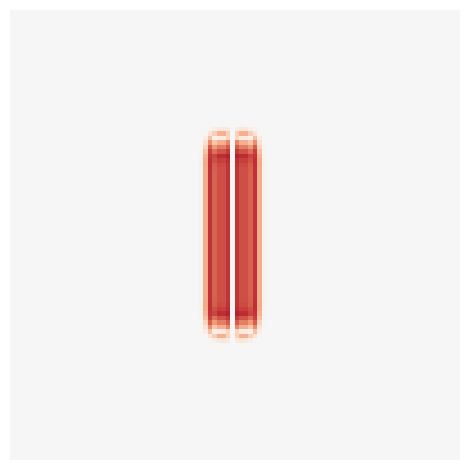

In [70]:
Utils.plot_rb(sol[905][:,:,1,1])

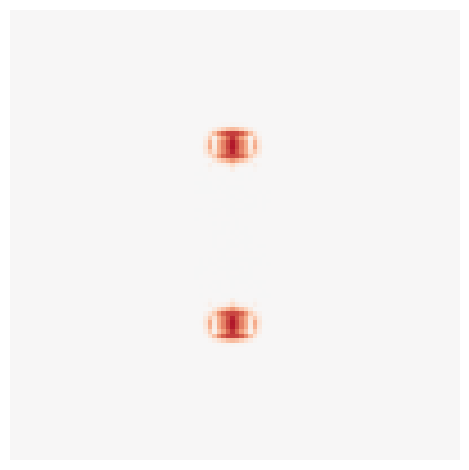

In [59]:
Utils.plot_rb(sol[905][:,:,2,1])

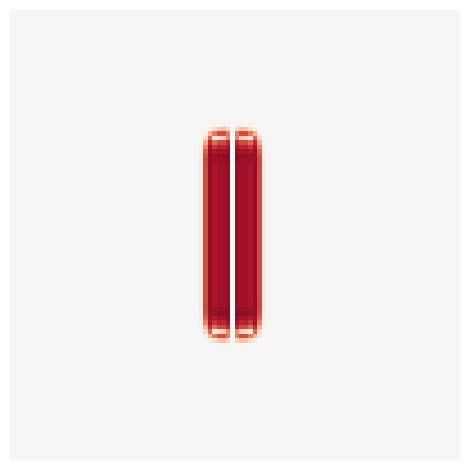

In [60]:
Utils.plot_rb(sol[905][:,:,3,1])

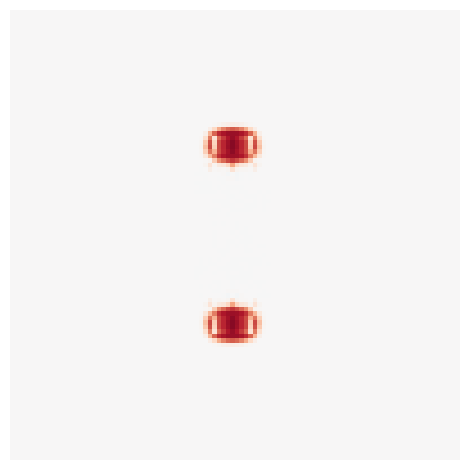

In [61]:
Utils.plot_rb(sol[905][:,:,4,1])

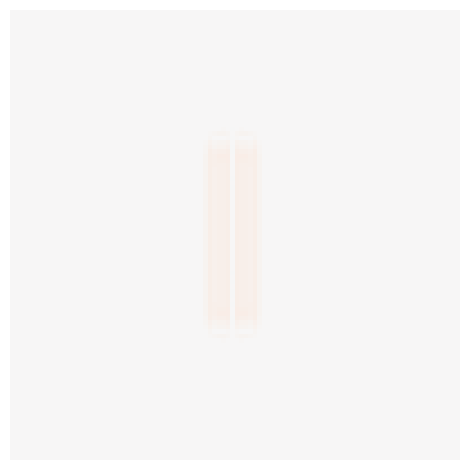

In [62]:
Utils.plot_rb(sol[905][:,:,5,1])

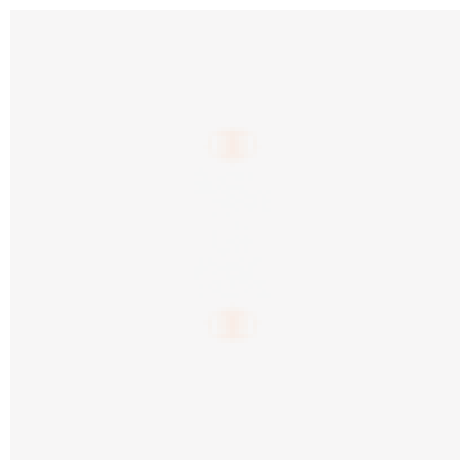

In [63]:
Utils.plot_rb(sol[905][:,:,6,1])

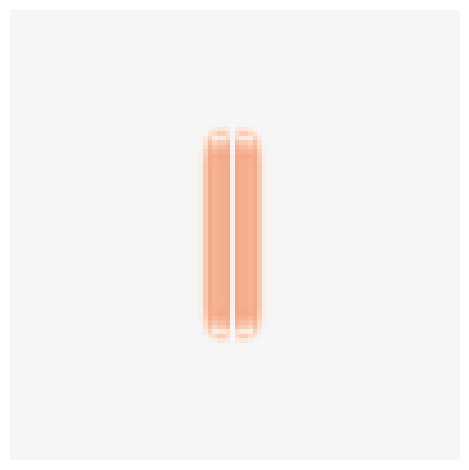

In [64]:
Utils.plot_rb(sol[905][:,:,7,1])

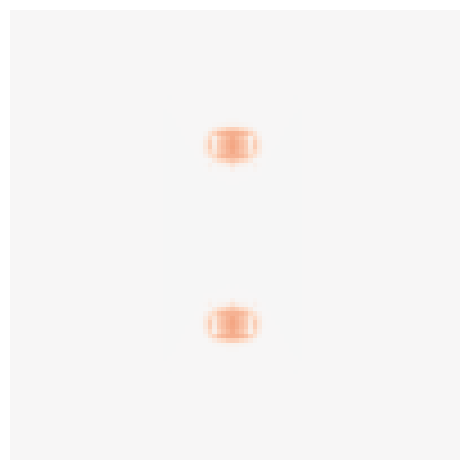

In [65]:
Utils.plot_rb(sol[905][:,:,8,1])

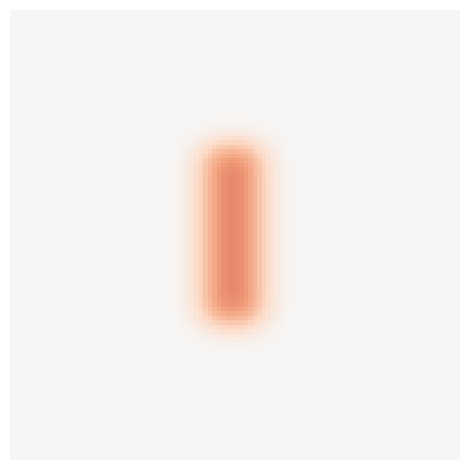

In [66]:
Utils.plot_rb(sol[905][:,:,9,1])

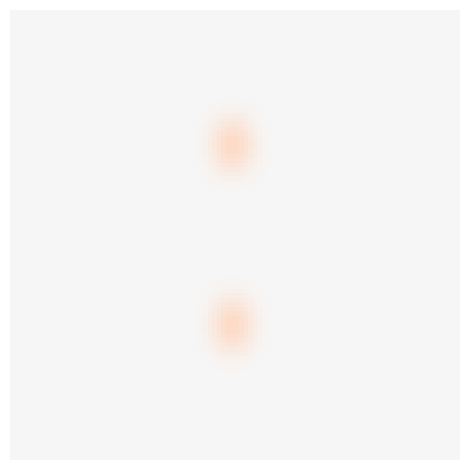

In [67]:
Utils.plot_rb(sol[905][:,:,10,1])

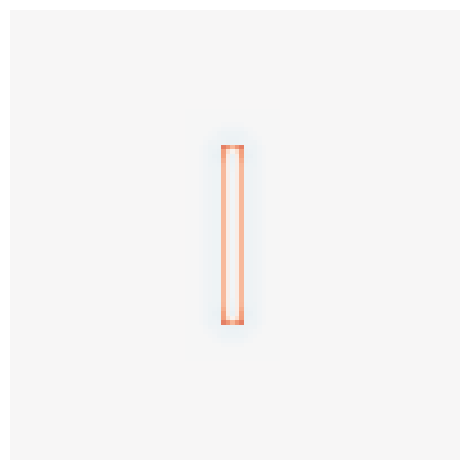

In [68]:
Utils.plot_rb(sol[905][:,:,11,1])

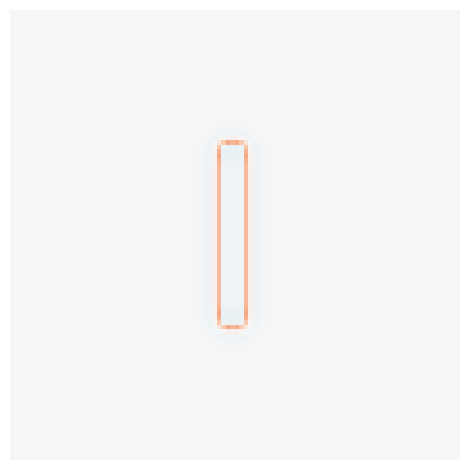

In [69]:
Utils.plot_rb(sol[905][:,:,12,1])

In [7]:
f = LaminartGPU.MyFunction(
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    x_lgn, C, H_z, V_temp_1, V_temp_2, A_temp, B_temp);

In [76]:
fa = LaminartGPU.MyFunctionnnn(
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    x_lgn, C, H_z, V_temp_1, V_temp_2, A_temp, B_temp);

In [196]:
prob= ODEProblem(f, u0, tspan, p);

In [81]:
prob1= ODEProblem(fa, u0, tspan, p);

In [18]:
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

In [197]:
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

In [ ]:
@benchmark sol = solve(prob)

changed to ff.x=x_ etc from ff.x= CuArray(x_) in MyFunction

In [198]:
@benchmark sol = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  1.82 GiB
  allocs estimate:  41566596
  --------------
  minimum time:     36.681 s (2.04% GC)
  median time:      36.681 s (2.04% GC)
  mean time:        36.681 s (2.04% GC)
  maximum time:     36.681 s (2.04% GC)
  --------------
  samples:          1
  evals/sample:     1

In [199]:
@benchmark sol = solve(prob, save_on=false)

BenchmarkTools.Trial: 
  memory estimate:  1.81 GiB
  allocs estimate:  41514217
  --------------
  minimum time:     34.729 s (2.05% GC)
  median time:      34.729 s (2.05% GC)
  mean time:        34.729 s (2.05% GC)
  maximum time:     34.729 s (2.05% GC)
  --------------
  samples:          1
  evals/sample:     1

In [200]:
@benchmark sol = solve(prob, save_on=false, alias_u0=true)

InterruptException: InterruptException:

In [201]:
@benchmark sol = solve(prob, save_on=false, save_start=false)


Stacktrace:
 [1] getproperty at ./Base.jl:26 [inlined]
 [2] macro expansion at /mnt/storage_1/users/cullinanen/.julia/packages/TimerOutputs/dVnaw/src/TimerOutput.jl:206 [inlined]
 [3] macro expansion at /mnt/storage_1/users/cullinanen/.julia/packages/CUDA/h38pe/src/memory.jl:274 [inlined]
 [4] macro expansion at ./util.jl:234 [inlined]
 [5] free at /mnt/storage_1/users/cullinanen/.julia/packages/CUDA/h38pe/src/memory.jl:273 [inlined]
 [6] _unsafe_free!(::CuArray{Float32,4,Nothing}) at /mnt/storage_1/users/cullinanen/.julia/packages/CUDA/h38pe/src/array.jl:53
 [7] unsafe_free!(::CuArray{Float32,4,Nothing}) at /mnt/storage_1/users/cullinanen/.julia/packages/CUDA/h38pe/src/array.jl:42
 [8] ntuple at ./ntuple.jl:43 [inlined]
 [9] copy(::Base.Broadcast.Broadcasted{Base.Broadcast.Style{Tuple},Nothing,typeof(Core.Typeof),Tuple{Tuple{CUDA.CuKernelContext,CuDeviceArray{Float32,4,CUDA.AS.Global},Base.Broadcast.Broadcasted{Nothing,NTuple{4,Base.OneTo{Int64}},typeof(*),Tuple{Base.Broadcast.Broadc

InterruptException()


BenchmarkTools.Trial: 
  memory estimate:  4.44 GiB
  allocs estimate:  102087800
  --------------
  minimum time:     88.512 s (1.59% GC)
  median time:      88.512 s (1.59% GC)
  mean time:        88.512 s (1.59% GC)
  maximum time:     88.512 s (1.59% GC)
  --------------
  samples:          1
  evals/sample:     1

In [8]:
f_nm = LaminartGPU.MyFunction_nm(
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    x_lgn, C, H_z, V_temp_1, V_temp_2, A_temp, B_temp);

In [9]:
prob_nm= ODEProblem(f_nm, u0, tspan, p);

In [10]:
@benchmark sol_nm = solve(prob_nm)

InterruptException: InterruptException:

In [12]:
f_nm.x

100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [18]:
@time f_nm.x .= u0[:, :, 1:p.K,:]

  0.001022 seconds (160 allocations: 5.188 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [19]:
@time f.x .= u0[:, :, 1:p.K,:]

  0.000491 seconds (174 allocations: 5.516 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [57]:
@benchmark sol = solve(prob1)

BenchmarkTools.Trial: 
  memory estimate:  6.65 GiB
  allocs estimate:  43379634
  --------------
  minimum time:     38.525 s (2.30% GC)
  median time:      38.525 s (2.30% GC)
  mean time:        38.525 s (2.30% GC)
  maximum time:     38.525 s (2.30% GC)
  --------------
  samples:          1
  evals/sample:     1

ArgumentError: ArgumentError: reducing over an empty collection is not allowed

In [83]:
@benchmark sol = solve(prob1, save_on=false)

BenchmarkTools.Trial: 
  memory estimate:  6.65 GiB
  allocs estimate:  43307302
  --------------
  minimum time:     38.748 s (2.33% GC)
  median time:      38.748 s (2.33% GC)
  mean time:        38.748 s (2.33% GC)
  maximum time:     38.748 s (2.33% GC)
  --------------
  samples:          1
  evals/sample:     1

In [208]:
CUDA.device_reset!(dev::CuDevice=device())

ErrorException: syntax: invalid keyword argument name "dev::CuDevice"

In [91]:
du = similar(u0)
@time f(du,u0,p,1)

MethodError: MethodError: no method matching (::MEngProject.LaminartGPU.MyFunctionn{CuArray{Float32,4,Nothing}})(::CuArray{Float32,4,Nothing}, ::CuArray{Float32,4,Nothing}, ::NamedTuple{(:K, :δ_v, :δ_c, :δ_m, :δ_z, :δ_s, :σ_1, :C_1, :C_2, :σ_2, :γ, :α, :ϕ, :Γ, :v_21, :μ, :ν, :n, :att, :η_p, :η_m, :λ, :a_23_ex, :a_23_in, :v12_6, :v12_4, :ψ, :C_AB_l, :H_σ_x, :H_σ_y, :H_fact, :H_l, :T_fact, :T_p_m, :T_v2_fact, :H_size, :W_size, :lgn_equ_u, :lgn_equ_A, :lgn_equ_B, :filling, :W_l, :k_gauss_1, :k_gauss_2, :k_C_A, :k_C_B, :k_x_lgn, :k_W_p, :k_W_m, :k_H, :k_T_p, :k_T_m, :k_T_p_v2, :k_T_m_v2, :dim_i, :dim_j, :x_V2, :ν_pw_n, :I, :r),Tuple{Int64,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Int64,Float32,Float32,Float32,Int64,Array{Float32,1},Float32,Float32,Int64,Int64,Float32,Float32,Float32,String,Int64,CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},Int64,Int64,CuArray{Float32,4,Nothing},Float32,CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing}}}, ::Int64)

In [92]:
f

(::MEngProject.LaminartGPU.MyFunctionn{CuArray{Float32,4,Nothing}}) (generic function with 0 methods)

In [93]:
f(u0, u0, p, 1)

MethodError: MethodError: no method matching (::MEngProject.LaminartGPU.MyFunctionn{CuArray{Float32,4,Nothing}})(::CuArray{Float32,4,Nothing}, ::CuArray{Float32,4,Nothing}, ::NamedTuple{(:K, :δ_v, :δ_c, :δ_m, :δ_z, :δ_s, :σ_1, :C_1, :C_2, :σ_2, :γ, :α, :ϕ, :Γ, :v_21, :μ, :ν, :n, :att, :η_p, :η_m, :λ, :a_23_ex, :a_23_in, :v12_6, :v12_4, :ψ, :C_AB_l, :H_σ_x, :H_σ_y, :H_fact, :H_l, :T_fact, :T_p_m, :T_v2_fact, :H_size, :W_size, :lgn_equ_u, :lgn_equ_A, :lgn_equ_B, :filling, :W_l, :k_gauss_1, :k_gauss_2, :k_C_A, :k_C_B, :k_x_lgn, :k_W_p, :k_W_m, :k_H, :k_T_p, :k_T_m, :k_T_p_v2, :k_T_m_v2, :dim_i, :dim_j, :x_V2, :ν_pw_n, :I, :r),Tuple{Int64,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Int64,Float32,Float32,Float32,Int64,Array{Float32,1},Float32,Float32,Int64,Int64,Float32,Float32,Float32,String,Int64,CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},Int64,Int64,CuArray{Float32,4,Nothing},Float32,CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing}}}, ::Int64)

In [ ]:
solcpu= Array(sol)

In [ ]:
@code_warntype LaminartGPU.MyFunctionnn(
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    x_lgn, C, H_z, V_temp_1, V_temp_2, A_temp, B_temp)

In [ ]:
CUDA.device_reset!(dev::CuDevice=device())

In [ ]:
f

In [ ]:
f.dv_m

In [ ]:
x_ = @view u[:, :, 1:p.K,:]

In [ ]:
f.x = CuArray(x_)

In [33]:
sol[5]

100×100×12×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.

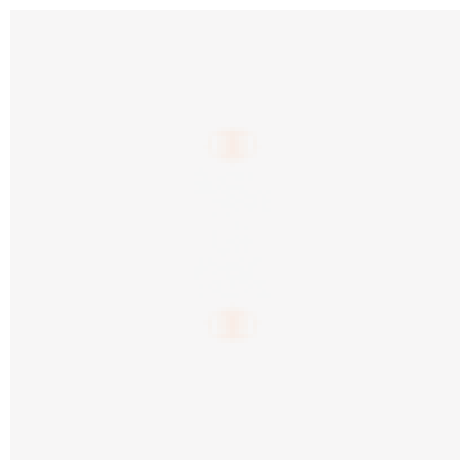

In [52]:
Utils.plot_rb(sol[905][:,:,6,1])

ArgumentError: ArgumentError: Image has max 1.128199e16,outside range

In [24]:
sol

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

## Try making struct to hold arrays eg f.x = x[:,:,:,:]
### first: BM how long that copy takes

In [ ]:
mutable struct testtt
    y::AbstractArray
end

In [ ]:
x= testtt(@view u0[:,:,1:2,:])

In [ ]:
yy = @view u0[:,:,1:2,:]
yyy = yy[:,:,:,:]

In [ ]:
@benchmark x.y = yyy

In [ ]:
x.y

In [ ]:
@benchmark begin
# x.y = @view u0[:,:,1:2,:]
x.y = yy[:,:,:,:]
end

In [ ]:

@benchmark begin
x.y = @view u0[:,:,1:2,:]
x.y = CuArray(x.y)
end

In [ ]:
x.y

In [ ]:
typeof(@view u0[:,:,1:2,:])

In [ ]:
typeof((@view u0[:,:,1:2,:])[:,:,:,:])

In [ ]:
xx = (@view u0[:,:,1:2,:])[:,:,:,:]
@. xx[:,:,1,:] = 1 

In [ ]:
@view u0[:,:,1:2,:][:,:,:,:]

In [ ]:
xx

In [ ]:
u0[:,:,1:2,:]

In [ ]:
mutable struct testta
    ya::AbstractArray
    yb::AbstractArray
end

In [ ]:
yaa = @view u0[:,:,1:2,:]
yba = CuArray(yaa)
x = testta(yaa, yba)

In [ ]:
x.ya

In [ ]:
x.yb

In [ ]:
@. x.yb[:,:,1,:] = 3f0

In [ ]:
x.yb

In [ ]:
x.ya

In [ ]:
@. x.ya = x.yb

In [ ]:
x.ya

In [ ]:
@benchmark begin
    x.ya = @view u0[:,:,1:2,:]
    x.yb = x.ya[:,:,:,:]
    @. x.yb = 4f0
    @. x.ya = x.yb
end

In [ ]:
@benchmark begin
    x.ya = @view u0[:,:,1:2,:]
    x.yb = CuArray(x.ya)
    @. x.yb = 4f0
    @. x.ya = x.yb
end

In [ ]:
@benchmark begin
    x.ya = @view u0[:,:,1:2,:]
    @. x.yb = CuArray(x.ya)
    @. x.yb = 4f0
    @. x.ya = x.yb
end

In [ ]:
@benchmark begin
    yana = @view u0[:,:,1:2,:]
    ybna = CuArray(yana)
    @. ybna = 4f0
    @. yana = ybna
end

In [ ]:
yanaa = @view u0[:,:,1:2,:]
@time  ybnc = CuArray(yanaa)

In [ ]:
x_lgn = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1))
C = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1))
H_z = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1));
V_temp_1 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1));
V_temp_2 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1));
A_temp = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1));
B_temp = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1));

In [97]:
t= cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1))
t1= cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1))

100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [103]:
@benchmark ta = @view t[:, :, :,:]

BenchmarkTools.Trial: 
  memory estimate:  96 bytes
  allocs estimate:  1
  --------------
  minimum time:     3.971 μs (0.00% GC)
  median time:      4.023 μs (0.00% GC)
  mean time:        4.030 μs (0.00% GC)
  maximum time:     11.779 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [105]:
@benchmark t1 = @view t[:, :, :,:]

BenchmarkTools.Trial: 
  memory estimate:  176 bytes
  allocs estimate:  4
  --------------
  minimum time:     2.876 μs (0.00% GC)
  median time:      2.909 μs (0.00% GC)
  mean time:        2.918 μs (0.00% GC)
  maximum time:     14.290 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     9

In [106]:
t1

100×100×1×1 CuArray{Float32,4,CuArray{Float32,4,Nothing}}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0 

In [116]:
t = similar(u0)
tt = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1))
ttt = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1))

100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [109]:
@benchmark tp = @view t[:,:,1:1,:]

BenchmarkTools.Trial: 
  memory estimate:  176 bytes
  allocs estimate:  4
  --------------
  minimum time:     4.010 μs (0.00% GC)
  median time:      4.052 μs (0.00% GC)
  mean time:        4.073 μs (0.00% GC)
  maximum time:     9.525 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [113]:
@benchmark tt = @view t[:,:,1:1,:]

BenchmarkTools.Trial: 
  memory estimate:  176 bytes
  allocs estimate:  4
  --------------
  minimum time:     4.033 μs (0.00% GC)
  median time:      4.229 μs (0.00% GC)
  mean time:        4.237 μs (0.00% GC)
  maximum time:     9.280 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [119]:
tt = @view t[:,:,1:1,:];
typeof(tt)

SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}

In [132]:
@benchmark ttt = CuArray(tt)

BenchmarkTools.Trial: 
  memory estimate:  43.44 KiB
  allocs estimate:  116
  --------------
  minimum time:     120.878 μs (0.00% GC)
  median time:      124.929 μs (0.00% GC)
  mean time:        133.186 μs (2.90% GC)
  maximum time:     20.577 ms (73.18% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [127]:
typeof(tt)

SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}

In [126]:
tttt = similar(tt);
typeof(tttt)

CuArray{Float32,4,Nothing}

In [128]:
ttttt = tt

100×100×1×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:1, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [129]:
tt[1,1,1,1]

0.0f0

In [130]:
@benchmark ttt = tt[:,:,:,:]

BenchmarkTools.Trial: 
  memory estimate:  2.44 MiB
  allocs estimate:  60007
  --------------
  minimum time:     217.929 ms (0.00% GC)
  median time:      221.849 ms (0.00% GC)
  mean time:        221.752 ms (0.00% GC)
  maximum time:     223.426 ms (0.00% GC)
  --------------
  samples:          23
  evals/sample:     1

In [131]:
ttt = tt[:,:,:,:],
typeof(ttt)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], CuArray{Float32,4,Nothing})

In [ ]:
@benchmark @. t = ff.x

In [149]:
du = u0
u = u0

100×100×12×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.

In [158]:
@time f(du, u, p, 1)
ff = f

  0.011061 seconds (7.72 k allocations: 1.238 MiB)


(::MEngProject.LaminartGPU.MyFunction{CuArray{Float32,4,Nothing}}) (generic function with 1 method)

In [168]:
# @time LaminartGPU.fun_x_lgn!(ff.x_lgn, ff.x, p)
# @time          LaminartGPU.fun_v_C!(ff.C, ff.v_p, ff.v_m, ff.V_temp_1, ff.V_temp_2, ff.A_temp, ff.B_temp, p)
# @time          LaminartGPU.fun_H_z!(ff.H_z, ff.z, p)
# @time          LaminartGPU.fun_dv!(ff.dv_p, ff.v_p, p.r, ff.x_lgn, p)
# @time        LaminartGPU.fun_dv!(ff.dv_m, ff.v_m, .-p.r, ff.x_lgn, p)
# @time    LaminartGPU.fun_dx_v1!(ff.dx, ff.x, ff.C, ff.z, p.x_V2, p)
# @time         LaminartGPU.fun_dy!(ff.dy, ff.y, ff.C, ff.x, ff.m, p)
# @time          LaminartGPU.fun_dm!(ff.dm, ff.m, ff.x, p)
# @time          LaminartGPU.fun_dz!(ff.dz, ff.z, ff.y, ff.H_z, ff.s, p)
@time      LaminartGPU.fun_ds!(ff.ds, ff.s, ff.H_z, p)

  0.000861 seconds (383 allocations: 15.938 KiB)


In [169]:
@time x_ = @view u[:, :, 1:p.K,:]

  0.000127 seconds (5 allocations: 208 bytes)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [170]:
ff.x = CuArray(x_)

100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [171]:
@time y_ = @view u[:, :, p.K+1:2*p.K,:]

  0.000137 seconds (5 allocations: 208 bytes)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 3:4, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [172]:
@time ff.y = CuArray(y_)

  0.000916 seconds (137 allocations: 82.953 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [173]:
x_ = @view u[:, :, 1:p.K,:]
        y_ = @view u[:, :, p.K+1:2*p.K,:]
        m_ = @view u[:, :, 2*p.K+1:3*p.K,:]
        z_ = @view u[:, :, 3*p.K+1:4*p.K,:]
        s_ = @view u[:, :, 4*p.K+1:5*p.K,:]

        v_p_ = @view u[:, :, 5*p.K+1:5*p.K+1,:]
        v_m_ = @view u[:, :, 5*p.K+2:5*p.K+2,:]

        dx_ = @view du[:, :, 1:p.K,:]
        dy_ = @view du[:, :, p.K+1:2*p.K,:]
        dm_ = @view du[:, :, 2*p.K+1:3*p.K,:]
        dz_ = @view du[:, :, 3*p.K+1:4*p.K,:]
        ds_ = @view du[:, :, 4*p.K+1:5*p.K,:]

        dv_p_ = @view du[:, :, 5*p.K+1:5*p.K+1,:]
        dv_m_ = @view du[:, :, 5*p.K+2:5*p.K+2,:]

100×100×1×1 view(::CuArray{Float32,4,Nothing}, :, :, 12:12, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    

In [175]:
@time begin
x_ = @view u[:, :, 1:p.K,:]
        y_ = @view u[:, :, p.K+1:2*p.K,:]
        m_ = @view u[:, :, 2*p.K+1:3*p.K,:]
        z_ = @view u[:, :, 3*p.K+1:4*p.K,:]
        s_ = @view u[:, :, 4*p.K+1:5*p.K,:]

        v_p_ = @view u[:, :, 5*p.K+1:5*p.K+1,:]
        v_m_ = @view u[:, :, 5*p.K+2:5*p.K+2,:]

        dx_ = @view du[:, :, 1:p.K,:]
        dy_ = @view du[:, :, p.K+1:2*p.K,:]
        dm_ = @view du[:, :, 2*p.K+1:3*p.K,:]
        dz_ = @view du[:, :, 3*p.K+1:4*p.K,:]
        ds_ = @view du[:, :, 4*p.K+1:5*p.K,:]

        dv_p_ = @view du[:, :, 5*p.K+1:5*p.K+1,:]
        dv_m_ = @view du[:, :, 5*p.K+2:5*p.K+2,:]
end

  0.000185 seconds (70 allocations: 2.844 KiB)


100×100×1×1 view(::CuArray{Float32,4,Nothing}, :, :, 12:12, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    

In [176]:
@time begin
ff.x = CuArray(x_)
        ff.y = CuArray(y_)
        ff.m =  CuArray(m_)
        ff.z =  CuArray(z_)
        ff.s = CuArray(s_)

        ff.v_p =  CuArray(v_p_)
        ff.v_m =  CuArray(v_m_)

        ff.dx =  CuArray(dx_)
        ff.dy =  CuArray(dy_)
        ff.dm =  CuArray(dm_)
        ff.dz =  CuArray(dz_)
        ff.ds =  CuArray(ds_)

        ff.dv_p =  CuArray(dv_p_)
        ff.dv_m =  CuArray(dv_m_)
end

  0.003369 seconds (1.81 k allocations: 1002.125 KiB)


100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [177]:
@time begin
ff.x = CuArray(x_)
        ff.y .= CuArray(y_)
        ff.m .=  CuArray(m_)
        ff.z .=  CuArray(z_)
        ff.s .= CuArray(s_)

        ff.v_p .=  CuArray(v_p_)
        ff.v_m .=  CuArray(v_m_)

        ff.dx .=  CuArray(dx_)
        ff.dy .=  CuArray(dy_)
        ff.dm .=  CuArray(dm_)
        ff.dz .=  CuArray(dz_)
        ff.ds .=  CuArray(ds_)

        ff.dv_p .=  CuArray(dv_p_)
        ff.dv_m .=  CuArray(dv_m_)
end

  0.004156 seconds (2.49 k allocations: 1.002 MiB)


100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [179]:
@time begin
  LaminartGPU.fun_x_lgn!(ff.x_lgn, ff.x, p)
        LaminartGPU.fun_v_C!(ff.C, ff.v_p, ff.v_m, ff.V_temp_1, ff.V_temp_2, ff.A_temp, ff.B_temp, p)
        LaminartGPU.fun_H_z!(ff.H_z, ff.z, p)

        LaminartGPU.fun_dv!(ff.dv_p, ff.v_p, p.r, ff.x_lgn, p)
        LaminartGPU.fun_dv!(ff.dv_m, ff.v_m, .-p.r, ff.x_lgn, p)
        LaminartGPU.fun_dx_v1!(ff.dx, ff.x, ff.C, ff.z, p.x_V2, p)
        LaminartGPU.fun_dy!(ff.dy, ff.y, ff.C, ff.x, ff.m, p)
        LaminartGPU.fun_dm!(ff.dm, ff.m, ff.x, p)
        LaminartGPU.fun_dz!(ff.dz, ff.z, ff.y, ff.H_z, ff.s, p)
        LaminartGPU.fun_ds!(ff.ds, ff.s, ff.H_z, p)
end

  0.037345 seconds (6.04 k allocations: 293.156 KiB)


In [180]:
@time begin
@. x_ = ff.x
        @. y_ =ff.y
        @. m_ =ff.m
        @. z_ = ff.z
        @. s_ = ff.s

        @. v_p_ = ff.v_p
        @. v_m_ = ff.v_m

        @. dx_ = ff.dx
        @. dy_ = ff.dy
        @. dm_ = ff.dm
        @. dz_ = ff.dz
        @. ds_ = ff.ds

		@. dv_p_ = ff.dv_p
        @. dv_m_ = ff.dv_m
end

  0.001749 seconds (1.32 k allocations: 61.453 KiB)


100×100×1×1 view(::CuArray{Float32,4,Nothing}, :, :, 12:12, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    

In [181]:
@time begin
        ff.x .= CuArray(x_)
        ff.y .= CuArray(y_)
        ff.m .=  CuArray(m_)
        ff.z .=  CuArray(z_)
        ff.s .= CuArray(s_)

        ff.v_p .=  CuArray(v_p_)
        ff.v_m .=  CuArray(v_m_)

        ff.dx .=  CuArray(dx_)
        ff.dy .=  CuArray(dy_)
        ff.dm .=  CuArray(dm_)
        ff.dz .=  CuArray(dz_)
        ff.ds .=  CuArray(ds_)

        ff.dv_p .=  CuArray(dv_p_)
        ff.dv_m .=  CuArray(dv_m_)
end

  0.003795 seconds (2.54 k allocations: 1.004 MiB)


100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [182]:
@time begin
ff.x = CuArray(x_)
       @. ff.y = CuArray(y_)
        ff.m =  CuArray(m_)
        ff.z =  CuArray(z_)
        ff.s = CuArray(s_)

        ff.v_p .=  CuArray(v_p_)
        ff.v_m .=  CuArray(v_m_)

        ff.dx .=  CuArray(dx_)
        ff.dy .=  CuArray(dy_)
        ff.dm .=  CuArray(dm_)
        ff.dz .=  CuArray(dz_)
        ff.ds .=  CuArray(ds_)

        ff.dv_p .=  CuArray(dv_p_)
        ff.dv_m .=  CuArray(dv_m_)
end

GPUCompiler.InvalidIRError: InvalidIRError: compiling kernel broadcast(CUDA.CuKernelContext, CuDeviceArray{Float32,4,CUDA.AS.Global}, Base.Broadcast.Broadcasted{Nothing,NTuple{4,Base.OneTo{Int64}},CUDA.var"#869#870"{CuArray},Tuple{Base.Broadcast.Extruded{SubArray{Float32,4,CuDeviceArray{Float32,4,CUDA.AS.Global},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},NTuple{4,Bool},NTuple{4,Int64}}}}) resulted in invalid LLVM IR
Reason: unsupported dynamic function invocation (call to CuArray)
Stacktrace:
 [1] #869 at /mnt/storage_1/users/cullinanen/.julia/packages/CUDA/h38pe/src/broadcast.jl:21
 [2] _broadcast_getindex_evalf at broadcast.jl:631
 [3] _broadcast_getindex at broadcast.jl:604
 [4] getindex at broadcast.jl:564
 [5] #20 at /mnt/storage_1/users/cullinanen/.julia/packages/GPUArrays/4W5rW/src/host/broadcast.jl:59

In [187]:
 @time ff.y = CuArray(y_)

  0.000546 seconds (130 allocations: 82.750 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [186]:
 @time ff.y .= y_

  0.000507 seconds (105 allocations: 4.922 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [188]:
@time begin
@. ff.x = x_
@. ff.y = y_
@. ff.m =  m_
@. ff.z =  z_
@. ff.s = s_

@. ff.v_p =  v_p_
@. ff.v_m =  v_m_

@. ff.dx = dx_
@. ff.dy =  dy_
@. ff.dm =  dm_
@. ff.dz =  dz_
@. ff.ds =  ds_

@. ff.dv_p =  dv_p_
@. ff.dv_m =  dv_m_
end

  0.002197 seconds (1.37 k allocations: 66.062 KiB)


100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [189]:
ff.x

100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [190]:
x_

100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [24]:
@. f.x = @view u0[:, :, 1:p.K,:]
@. f.x = f.x =11f0

100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 11.0  11.0  11.0  11.0  11.0  11.0  …  11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0  …  11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0  …  11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0 

In [25]:
u0[:, :, 1:p.K,:]

100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [26]:
@time @. f.x = @view u0[:, :, 1:p.K,:]

  0.000457 seconds (103 allocations: 4.922 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [27]:
@time begin
    x_ = @view u0[:, :, 1:p.K,:]
    @. f.x = x_
    @. x_ = f.x
end

  0.031826 seconds (1.66 k allocations: 85.125 KiB)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [ ]:
@time begin
    x_ = @view u0[:, :, 1:p.K,:]
    @. f.x = x_
    @. x_ = f.x
end

In [28]:
@. @view u0[:, :, 1:p.K,:] = f.x

LoadError: ArgumentError: Invalid use of @view macro: argument must be a reference expression A[...].

In [30]:
@time begin
    @. f.x = @view u0[:, :, 1:p.K,:]
    @. u0[:, :, 1:p.K,:] = f.x
end

  0.000708 seconds (205 allocations: 9.578 KiB)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [7]:
f_1 = LaminartGPU.MyFunction_1(
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    x_lgn, C, H_z, V_temp_1, V_temp_2, A_temp, B_temp);

In [8]:
prob_1 = ODEProblem(f_1, u0, tspan, p);

In [38]:
@tsol_1 = solve(prob_1)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

In [9]:
@benchmark sol_1 = solve(prob_1)

InterruptException: InterruptException:

In [16]:
f_2 = LaminartGPU.MyFunction_2(
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    x_lgn, C, H_z, V_temp_1, V_temp_2, A_temp, B_temp);

In [17]:
prob_2 = ODEProblem(f_2, u0, tspan, p);

In [18]:
@benchmark sol_2 = solve(prob_2)

BenchmarkTools.Trial: 
  memory estimate:  1.48 GiB
  allocs estimate:  34262638
  --------------
  minimum time:     26.504 s (1.97% GC)
  median time:      26.504 s (1.97% GC)
  mean time:        26.504 s (1.97% GC)
  maximum time:     26.504 s (1.97% GC)
  --------------
  samples:          1
  evals/sample:     1

In [20]:
sol_2 = solve(prob_2)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [29]:
@. ff.dx = ff.dx + 11f0;

In [24]:
ff = f_2
du = u0;

In [48]:
       y_ = @view du[:, :, 1:p.K,:];
@time begin

   @. y_ = ff.dx;
end

  0.000403 seconds (94 allocations: 4.375 KiB)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 22.0  22.0  22.0  22.0  22.0  22.0  …  22.0  22.0  22.0  22.0  22.0  22.0
 22.0  22.0  22.0  22.0  22.0  22.0     22.0  22.0  22.0  22.0  22.0  22.0
 22.0  22.0  22.0  22.0  22.0  22.0     22.0  22.0  22.0  22.0  22.0  22.0
 22.0  22.0  22.0  22.0  22.0  22.0     22.0  22.0  22.0  22.0  22.0  22.0
 22.0  22.0  22.0  22.0  22.0  22.0     22.0  22.0  22.0  22.0  22.0  22.0
 22.0  22.0  22.0  22.0  22.0  22.0  …  22.0  22.0  22.0  22.0  22.0  22.0
 22.0  22.0  22.0  22.0  22.0  22.0     22.0  22.0  22.0  22.0  22.0  22.0
 22.0  22.0  22.0  22.0  22.0  22.0     22.0  22.0  22.0  22.0  22.0  22.0
 22.0  22.0  22.0  22.0  22.0  22.0     22.0  22.0  22.0  22.0  22.0  22.0
 22.0  22.0  22.0  22.0  22.0  22.0     22.0  22.0  22.0  22.0  22.0  22.0
 22.0  22.0  22.0  22.0  22.0  22.0  …  22.0  22.0  22.0  22.0  22.0  22.0
 22.0  22.0  22.0  22.0  22.0  22.0     22.0  22.0  22.0  22.0  22.0  22.0
 22

In [45]:
@view du[:, :, 1:p.K,:]

100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [49]:
@time begin
      @.   du[:, :, 1:p.K,:]= ff.dz
end

  0.000431 seconds (102 allocations: 4.656 KiB)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [11]:
ff = f_2

(::MEngProject.LaminartGPU.MyFunction_2{CuArray{Float32,4,Nothing}}) (generic function with 1 method)

In [48]:
Utils.plot_rb(sol_2[300][:,:,6,1])

ArgumentError: ArgumentError: Image has max 2.2255492,outside range

In [78]:
a = nothing; GC.gc(true)

In [79]:
CUDA.reclaim()

0

In [80]:
CUDA.memory_status()

Effective GPU memory usage: 96.55% (10.786 GiB/11.172 GiB)
CUDA allocator usage: 10.624 GiB
BinnedPool usage: 10.624 GiB (10.624 GiB allocated, 0 bytes cached)


In [30]:
ff = f_1

(::MEngProject.LaminartGPU.MyFunction_1{CuArray{Float32,4,Nothing}}) (generic function with 1 method)

In [26]:
du = u0;

In [42]:
@time begin
    @. ff.dx = @view du[:, :, 1:p.K,:]
    @. ff.dx = ff.dx 
    dx_ = @view du[:, :, 1:p.K,:]
     @. dx_ = ff.dx
end

  0.000686 seconds (253 allocations: 11.344 KiB)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 33.0  33.0  33.0  33.0  33.0  33.0  …  33.0  33.0  33.0  33.0  33.0  33.0
 33.0  33.0  33.0  33.0  33.0  33.0     33.0  33.0  33.0  33.0  33.0  33.0
 33.0  33.0  33.0  33.0  33.0  33.0     33.0  33.0  33.0  33.0  33.0  33.0
 33.0  33.0  33.0  33.0  33.0  33.0     33.0  33.0  33.0  33.0  33.0  33.0
 33.0  33.0  33.0  33.0  33.0  33.0     33.0  33.0  33.0  33.0  33.0  33.0
 33.0  33.0  33.0  33.0  33.0  33.0  …  33.0  33.0  33.0  33.0  33.0  33.0
 33.0  33.0  33.0  33.0  33.0  33.0     33.0  33.0  33.0  33.0  33.0  33.0
 33.0  33.0  33.0  33.0  33.0  33.0     33.0  33.0  33.0  33.0  33.0  33.0
 33.0  33.0  33.0  33.0  33.0  33.0     33.0  33.0  33.0  33.0  33.0  33.0
 33.0  33.0  33.0  33.0  33.0  33.0     33.0  33.0  33.0  33.0  33.0  33.0
 33.0  33.0  33.0  33.0  33.0  33.0  …  33.0  33.0  33.0  33.0  33.0  33.0
 33.0  33.0  33.0  33.0  33.0  33.0     33.0  33.0  33.0  33.0  33.0  33.0
 33

In [83]:
img = convert(Array{Float32,2}, load(datadir("Iine_100_100_gs.png")));
img = reshape2d_4d(img)
img = cu(img)
r = similar(img)

p = LaminartGPU.kernels(img, Parameters.parameters);

LaminartGPU.I_u!(r, img, p)
temp_out = (I = img, r = r)
p = merge(p, temp_out);

In [84]:
tspan = (0.0f0, 5f0)
u0 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2,1));

In [85]:
img_ = convert(Array{Float32,2}, load(datadir("Iine_100_100_gs.png")));
img_ = reshape2d_4d(img_)
# img_ = cu(img)
r_ = similar(img_)

p_ = LaminartGPU.kernels_(img_, Parameters.parameters);

LaminartGPU.I_u!(r_, img_, p_)
temp_out_ = (I = img_, r = r_)
p_ = merge(p_, temp_out_);

In [86]:
# tspan = (0.0f0, 5f0)
u0_ = reshape(zeros(Float32, p_.dim_i, p_.dim_j*(5*p_.K+2)), p_.dim_i, p_.dim_j, 5*p_.K+2,1);

In [5]:
arr1 = u0[:, :, 1:p.K,:]
arr2 = u0[:, :, 1:1,:];

In [6]:
f = LaminartGPU.LamFunction(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [89]:
arr1_ = u0_[:, :, 1:p_.K,:]
arr2_ = u0_[:, :, 1:1,:];

In [90]:
f_ = LaminartGPU.LamFunction(
    similar(arr1_), # x
    similar(arr1_), # y
    similar(arr1_), # m
    similar(arr1_), # z
    similar(arr1_), # s
    similar(arr2_), # v_p
    similar(arr2_), # v_m
    similar(arr1_), # dx
    similar(arr1_), # dy
    similar(arr1_), # dm
    similar(arr1_), # dz
    similar(arr1_), # ds
    similar(arr2_), # dv_p
    similar(arr2_), # dv_m
    similar(arr2_), # x_lgn
    similar(arr1_), # C
    similar(arr1_), # H_z
    similar(arr2_), # V_temp1
    similar(arr2_), # V_temp2
    similar(arr1_), # A_temp
    similar(arr1_), # B_temp
    );

In [91]:
prob = ODEProblem(f, u0, tspan, p);

In [92]:
prob_ = ODEProblem(f_, u0_, tspan, p_);

In [93]:
sys = modelingtoolkitize(prob_)

KeyError: KeyError: key 'K' not found

In [95]:
prob_.f isa DiffEqBase.AbstractParameterizedFunction 
# &&
#                             return (prob.f.sys, prob.f.sys.states, prob.f.sys.ps)
    

false

In [96]:
@parameters t
    

(t,)

In [97]:
vars = reshape([Variable(:x, i)(t) for i in eachindex(prob_.u0)],size(prob_.u0))
    

100×100×12×1 Array{Operation,4}:
[:, :, 1, 1] =
   x₁(t)  x₁₀₁(t)  x₂₀₁(t)  x₃₀₁(t)  …  x₉₇₀₁(t)  x₉₈₀₁(t)   x₉₉₀₁(t)
   x₂(t)  x₁₀₂(t)  x₂₀₂(t)  x₃₀₂(t)     x₉₇₀₂(t)  x₉₈₀₂(t)   x₉₉₀₂(t)
   x₃(t)  x₁₀₃(t)  x₂₀₃(t)  x₃₀₃(t)     x₉₇₀₃(t)  x₉₈₀₃(t)   x₉₉₀₃(t)
   x₄(t)  x₁₀₄(t)  x₂₀₄(t)  x₃₀₄(t)     x₉₇₀₄(t)  x₉₈₀₄(t)   x₉₉₀₄(t)
   x₅(t)  x₁₀₅(t)  x₂₀₅(t)  x₃₀₅(t)     x₉₇₀₅(t)  x₉₈₀₅(t)   x₉₉₀₅(t)
   x₆(t)  x₁₀₆(t)  x₂₀₆(t)  x₃₀₆(t)  …  x₉₇₀₆(t)  x₉₈₀₆(t)   x₉₉₀₆(t)
   x₇(t)  x₁₀₇(t)  x₂₀₇(t)  x₃₀₇(t)     x₉₇₀₇(t)  x₉₈₀₇(t)   x₉₉₀₇(t)
   x₈(t)  x₁₀₈(t)  x₂₀₈(t)  x₃₀₈(t)     x₉₇₀₈(t)  x₉₈₀₈(t)   x₉₉₀₈(t)
   x₉(t)  x₁₀₉(t)  x₂₀₉(t)  x₃₀₉(t)     x₉₇₀₉(t)  x₉₈₀₉(t)   x₉₉₀₉(t)
  x₁₀(t)  x₁₁₀(t)  x₂₁₀(t)  x₃₁₀(t)     x₉₇₁₀(t)  x₉₈₁₀(t)   x₉₉₁₀(t)
  x₁₁(t)  x₁₁₁(t)  x₂₁₁(t)  x₃₁₁(t)  …  x₉₇₁₁(t)  x₉₈₁₁(t)   x₉₉₁₁(t)
  x₁₂(t)  x₁₁₂(t)  x₂₁₂(t)  x₃₁₂(t)     x₉₇₁₂(t)  x₉₈₁₂(t)   x₉₉₁₂(t)
  x₁₃(t)  x₁₁₃(t)  x₂₁₃(t)  x₃₁₃(t)     x₉₇₁₃(t)  x₉₈₁₃(t)   x₉₉₁₃(t)
       ⋮                             ⋱    

In [ ]:
params = prob_.p isa DiffEqBase.NullParameters ? [] :
             reshape([Variable(:α,i)() for i in eachindex(prob_.p)],size(prob_.p))
    

In [98]:
@derivatives D'~t

   

((D'~t),)

In [99]:
 rhs = [D(var) for var in vars];

In [103]:
params = p_

ErrorException: cannot assign a value to variable BenchmarkTools.params from module Main

In [102]:
    if DiffEqBase.isinplace(prob_)
        lhs = similar(vars, Any)
        prob_.f(lhs, vars, params, t)
    else
        lhs = prob.f(vars, params, t)
    end

ErrorException: type #params has no field K

In [112]:
        lhs = similar(vars, Any)
        f__(lhs, vars, p_, t)


┌ Warning: Slow fallback implementation invoked for conv!  You probably don't want this; check your datatypes.
│   yT = Expression
│   T1 = Operation
│   T2 = Float32
└ @ NNlib /mnt/storage_1/users/cullinanen/.julia/packages/NNlib/sSn9M/src/conv.jl:206


MethodError: MethodError: no method matching Expression(::Int64)
Closest candidates are:
  Expression(::T) where T<:Number at boot.jl:715
  Expression(!Matched::Bool) at /mnt/storage_1/users/cullinanen/.julia/packages/ModelingToolkit/fM618/src/utils.jl:26
  Expression(!Matched::Base.TwicePrecision) where T<:Number at twiceprecision.jl:243
  ...

In [108]:
@. f_.x  = @view vars[:, :, 1:p.K,:]

MethodError: MethodError: no method matching Float32(::Operation)
Closest candidates are:
  Float32(::T) where T<:Number at boot.jl:715
  Float32(!Matched::Int8) at float.jl:60
  Float32(!Matched::Int16) at float.jl:60
  ...

In [102]:
    if DiffEqBase.isinplace(prob_)
        lhs = similar(vars, Any)
        prob_.f(lhs, vars, params, t)
    else
        lhs = prob.f(vars, params, t)
    end

ErrorException: type #params has no field K

In [ ]:
    eqs = vcat([rhs[i] ~ lhs[i] for i in eachindex(prob_.u0)]...)

In [ ]:
    de = ODESystem(eqs,t,vec(vars),vec(params))

    de

In [110]:
arr1 = vars[:, :, 1:p.K,:]
arr2 = vars[:, :, 1:1,:];

In [111]:
f__ = LaminartGPU.LamFunction(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [113]:
LaminartGPU.fun_x_lgn!(f__.x_lgn, f__.x, p_)

┌ Warning: Slow fallback implementation invoked for conv!  You probably don't want this; check your datatypes.
│   yT = Expression
│   T1 = Operation
│   T2 = Float32
└ @ NNlib /mnt/storage_1/users/cullinanen/.julia/packages/NNlib/sSn9M/src/conv.jl:206


MethodError: MethodError: no method matching Expression(::Int64)
Closest candidates are:
  Expression(::T) where T<:Number at boot.jl:715
  Expression(!Matched::Bool) at /mnt/storage_1/users/cullinanen/.julia/packages/ModelingToolkit/fM618/src/utils.jl:26
  Expression(!Matched::Base.TwicePrecision) where T<:Number at twiceprecision.jl:243
  ...

In [11]:
f = LaminartGPU.LamFunction(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [12]:
du = similar(u0)
@code_warntype f(du,u0,p,0.0f0)

Variables
  ff::MEngProject.LaminartGPU.LamFunction{CuArray{Float32,4,Nothing}}
  du::CuArray{Float32,4,Nothing}
  u::CuArray{Float32,4,Nothing}
  p::NamedTuple{(:K, :δ_v, :δ_c, :δ_m, :δ_z, :δ_s, :σ_1, :C_1, :C_2, :σ_2, :γ, :α, :ϕ, :Γ, :v_21, :μ, :ν, :n, :att, :η_p, :η_m, :λ, :a_23_ex, :a_23_in, :v12_6, :v12_4, :ψ, :C_AB_l, :H_σ_x, :H_σ_y, :H_fact, :H_l, :T_fact, :T_p_m, :T_v2_fact, :H_size, :W_size, :lgn_equ_u, :lgn_equ_A, :lgn_equ_B, :filling, :W_l, :k_gauss_1, :k_gauss_2, :k_C_A, :k_C_B, :k_x_lgn, :k_W_p, :k_W_m, :k_H, :k_T_p, :k_T_m, :k_T_p_v2, :k_T_m_v2, :dim_i, :dim_j, :x_V2, :ν_pw_n, :I, :r),Tuple{Int64,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Int64,Float32,Float32,Float32,Int64,Array{Float32,1},Float32,Float32,Int64,Int64,Float32,Float32,Float32,String,Int64,CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},Cu

In [14]:
 @. f.x = @view u0[:, :, 1:p.K,:]

100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [16]:
@code_warntype  @. f.y = @view u[:, :, p.K+1:2*p.K,:]

Variables
  #self#::Core.Compiler.Const(@__dot__, false)
  __source__::LineNumberNode
  __module__::Module
  x::Expr

Body::Expr
1 ─      nothing
│   %2 = Base.Broadcast.__dot__(x)::Any
│   %3 = Base.Broadcast.esc(%2)::Expr
└──      return %3


In [17]:
f.y

100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [20]:
tt = typeof(@view u0[:, :, 1:p.K,:])

SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}

In [21]:
ttt = similar(tt)

MethodError: MethodError: no method matching SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}(::UndefInitializer, ::Tuple{})
Closest candidates are:
  SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}(::Any, ::Any, !Matched::Any, !Matched::Any) where {T, N, P, I, L} at subarray.jl:20

In [22]:
tt

SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}

In [31]:
f = LaminartGPU.LamFunction(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [35]:
f_ = LaminartGPU.LamFunction_(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [36]:
du = similar(u0)
du .= u0 .+2f0

100×100×12×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  …  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  …  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  …  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.

In [38]:
f_(du,u0,p,0.0f0)

In [39]:
du[:, :, 5*p.K+1:5*p.K+1,:]

100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [40]:
prob_ = ODEProblem(f_, u0, tspan, p);

In [41]:
sol = solve(prob_)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

In [42]:
@benchmark sol = solve(prob_)

BenchmarkTools.Trial: 
  memory estimate:  1.68 GiB
  allocs estimate:  37567630
  --------------
  minimum time:     27.645 s (2.16% GC)
  median time:      27.645 s (2.16% GC)
  mean time:        27.645 s (2.16% GC)
  maximum time:     27.645 s (2.16% GC)
  --------------
  samples:          1
  evals/sample:     1

In [83]:
f = LaminartGPU.LamFunction(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [44]:
prob = ODEProblem(f, u0, tspan, p); 

In [45]:
@benchmark sol = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  1.49 GiB
  allocs estimate:  34378046
  --------------
  minimum time:     27.782 s (1.68% GC)
  median time:      27.782 s (1.68% GC)
  mean time:        27.782 s (1.68% GC)
  maximum time:     27.782 s (1.68% GC)
  --------------
  samples:          1
  evals/sample:     1

In [46]:
du = similar(u0)
@time f_(du, u0, p, 0f0)

  0.022975 seconds (6.54 k allocations: 310.000 KiB)


In [47]:
du = similar(u0)
@time f(du, u0, p, 0f0)

  0.008101 seconds (5.80 k allocations: 267.672 KiB)


In [49]:
arr11 = @view u0[:, :, 1:p.K,:] 
arr21 = @view u0[:, :, 5*p.K+1:5*p.K+1,:];

In [58]:
f_ = LaminartGPU.LamFunction___(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr11), # dx
    similar(arr11), # dy
    similar(arr11), # dm
    similar(arr11), # dz
    similar(arr11), # ds
    similar(arr21), # dv_p
    similar(arr21), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [61]:
du = similar(u0)
@time f_(du, u0, p, 0f0)

  0.008818 seconds (5.35 k allocations: 3.912 MiB)


In [71]:
f_ = LaminartGPU.LamFunction_1(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [72]:
du = similar(u0)
@time f_(du, u0, p, 0f0)

  0.240769 seconds (324.32 k allocations: 21.134 MiB)


In [74]:
@time f_(du, u0, p, 0f0)

  0.016514 seconds (5.40 k allocations: 3.913 MiB)


In [75]:
f_2 = LaminartGPU.LamFunction_2(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
#     similar(arr1), # dx
#     similar(arr1), # dy
#     similar(arr1), # dm
#     similar(arr1), # dz
#     similar(arr1), # ds
#     similar(arr2), # dv_p
#     similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [82]:
du = similar(u0)
@time f_2(du, u0, p, 0f0)

  0.006660 seconds (6.38 k allocations: 304.812 KiB)


In [91]:
@time f_2(du, u0, p, 0f0)

  0.006769 seconds (6.39 k allocations: 305.016 KiB)


In [87]:
@time f(du, u0, p, 0f0)

  0.006703 seconds (5.81 k allocations: 267.656 KiB)


In [92]:
@benchmark f_2(du, u0, p, 0f0)

BenchmarkTools.Trial: 
  memory estimate:  304.73 KiB
  allocs estimate:  6377
  --------------
  minimum time:     4.387 ms (0.00% GC)
  median time:      4.470 ms (0.00% GC)
  mean time:        4.728 ms (2.31% GC)
  maximum time:     113.751 ms (60.97% GC)
  --------------
  samples:          1056
  evals/sample:     1

In [93]:
@benchmark f(du, u0, p, 0f0)

BenchmarkTools.Trial: 
  memory estimate:  267.38 KiB
  allocs estimate:  5798
  --------------
  minimum time:     4.490 ms (0.00% GC)
  median time:      4.552 ms (0.00% GC)
  mean time:        4.774 ms (2.06% GC)
  maximum time:     111.928 ms (60.22% GC)
  --------------
  samples:          1046
  evals/sample:     1

In [95]:
prob_2 = ODEProblem(f_2, u0, tspan,  p)

ODEProblem with uType CuArray{Float32,4,Nothing} and tType Float32. In-place: true
timespan: (0.0f0, 5.0f0)
u0: Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

In [96]:
sol_2 = solve(prob_2)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

In [97]:
@benchmark sol_2 = solve(prob_2)

BenchmarkTools.Trial: 
  memory estimate:  1.69 GiB
  allocs estimate:  37537763
  --------------
  minimum time:     28.816 s (2.26% GC)
  median time:      28.816 s (2.26% GC)
  mean time:        28.816 s (2.26% GC)
  maximum time:     28.816 s (2.26% GC)
  --------------
  samples:          1
  evals/sample:     1

In [98]:
@benchmark sol = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  1.49 GiB
  allocs estimate:  34396110
  --------------
  minimum time:     27.662 s (2.13% GC)
  median time:      27.662 s (2.13% GC)
  mean time:        27.662 s (2.13% GC)
  maximum time:     27.662 s (2.13% GC)
  --------------
  samples:          1
  evals/sample:     1

In [ ]:
 calck = false

In [101]:
@benchmark sol_3 = solve(prob, save_everystep=false)

BenchmarkTools.Trial: 
  memory estimate:  1.49 GiB
  allocs estimate:  34343680
  --------------
  minimum time:     29.128 s (2.06% GC)
  median time:      29.128 s (2.06% GC)
  mean time:        29.128 s (2.06% GC)
  maximum time:     29.128 s (2.06% GC)
  --------------
  samples:          1
  evals/sample:     1

In [102]:
@benchmark sol_3 = solve(prob, calck=false)

BenchmarkTools.Trial: 
  memory estimate:  1.49 GiB
  allocs estimate:  34396113
  --------------
  minimum time:     28.781 s (2.27% GC)
  median time:      28.781 s (2.27% GC)
  mean time:        28.781 s (2.27% GC)
  maximum time:     28.781 s (2.27% GC)
  --------------
  samples:          1
  evals/sample:     1

In [103]:
@benchmark sol_3 = solve(prob, calck=false, save_everystep=false)

BenchmarkTools.Trial: 
  memory estimate:  1.49 GiB
  allocs estimate:  34343681
  --------------
  minimum time:     28.905 s (2.05% GC)
  median time:      28.905 s (2.05% GC)
  mean time:        28.905 s (2.05% GC)
  maximum time:     28.905 s (2.05% GC)
  --------------
  samples:          1
  evals/sample:     1

In [104]:
sol_3[1]

UndefVarError: UndefVarError: sol_3 not defined

In [105]:
f = LaminartGPU.LamFunction(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [109]:
@time f(du, u0, p, 0.0f0)

  0.006309 seconds (5.19 k allocations: 247.328 KiB)


In [110]:
f = LaminartGPU.LamFunction(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [113]:
@time f(du, u0, p, 0.0f0)

  0.007051 seconds (5.80 k allocations: 267.484 KiB)


In [114]:
f = LaminartGPU.LamFunction(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [118]:
@time f(du, u0, p, 0.0f0)

  0.006191 seconds (5.13 k allocations: 246.156 KiB)


In [119]:
f = LaminartGPU.LamFunction(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [121]:
@time f(du, u0, p, 0.0f0)

  0.006268 seconds (5.20 k allocations: 248.266 KiB)


In [122]:
f = LaminartGPU.LamFunction(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [124]:
@time f(du, u0, p, 0.0f0)

  0.006102 seconds (5.14 k allocations: 247.094 KiB)


In [125]:
f = LaminartGPU.LamFunction(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [130]:
@time f(du, u0, p, 0.0f0)

  0.005568 seconds (5.13 k allocations: 246.250 KiB)


In [7]:
prob_4 = ODEProblem(f, u0, tspan, p)

ODEProblem with uType CuArray{Float32,4,Nothing} and tType Float32. In-place: true
timespan: (0.0f0, 5.0f0)
u0: Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

In [9]:
@time sol = solve(prob_4)

 27.920758 seconds (30.98 M allocations: 1.377 GiB, 2.38% gc time)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

In [9]:
using Traceur
du = similar(u0)
@trace f(du, u0, p, 0.0f0) 

┌ Warning: getindex returns Union{Colon, UnitRange{Int64}}
└ @ tuple.jl:24
┌ Warning: getindex returns Union{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}
└ @ tuple.jl:24
┌ Warning: getindex returns Union{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}
└ @ tuple.jl:24
┌ Warning: getindex returns Union{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}
└ @ tuple.jl:24
┌ Warning: dynamic dispatch to CUDA._cuview(A, I, CUDA.NonContiguous())
└ @ ~/.julia/packages/CUDA/h38pe/src/subarray.jl:24


ErrorException: type Symbol has no field wrapper

In [15]:
@time f(du, u0, p, 0.0f0) 

  0.005308 seconds (5.21 k allocations: 247.625 KiB)


In [49]:
f = LaminartGPU.LamFunction_001(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [50]:
@time f(du, u0, p, 0.0f0)

  0.432366 seconds (491.09 k allocations: 23.257 MiB)


In [51]:
prob = ODEProblem(f, u0, tspan, p)

ODEProblem with uType CuArray{Float32,4,Nothing} and tType Float32. In-place: true
timespan: (0.0f0, 5.0f0)
u0: Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

In [52]:
@benchmark sol = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  1.38 GiB
  allocs estimate:  30969690
  --------------
  minimum time:     22.953 s (2.23% GC)
  median time:      22.953 s (2.23% GC)
  mean time:        22.953 s (2.23% GC)
  maximum time:     22.953 s (2.23% GC)
  --------------
  samples:          1
  evals/sample:     1

In [53]:
@benchmark sol = solve(prob, save_everystep=false)

BenchmarkTools.Trial: 
  memory estimate:  1.38 GiB
  allocs estimate:  30910188
  --------------
  minimum time:     22.793 s (2.11% GC)
  median time:      22.793 s (2.11% GC)
  mean time:        22.793 s (2.11% GC)
  maximum time:     22.793 s (2.11% GC)
  --------------
  samples:          1
  evals/sample:     1

In [54]:
sol = solve(prob, save_everystep=false)

retcode: Success
Interpolation: 1st order linear
t: 2-element Array{Float32,1}:
 0.0
 5.0
u: 2-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 …

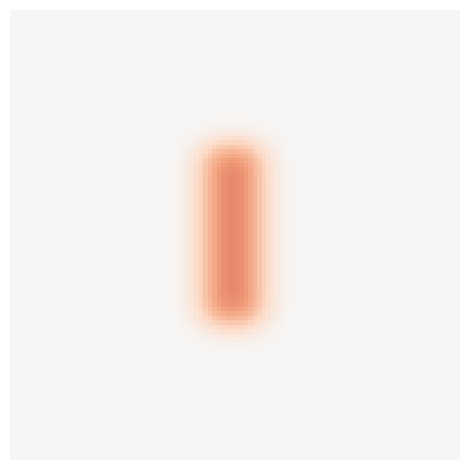

In [57]:
Utils.plot_rb(sol(5)[:,:,9,1])

In [35]:
f = LaminartGPU.LamFunction_002(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
#     similar(arr1), # dx
#     similar(arr1), # dy
#     similar(arr1), # dm
#     similar(arr1), # dz
#     similar(arr1), # ds
#     similar(arr2), # dv_p
#     similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [40]:
@time f(du, u0, p, 0.0f0)

  0.006654 seconds (6.07 k allocations: 313.422 KiB)


In [19]:
prob = ODEProblem(f, u0, tspan, p)

ODEProblem with uType CuArray{Float32,4,Nothing} and tType Float32. In-place: true
timespan: (0.0f0, 5.0f0)
u0: Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

In [20]:
@benchmark sol = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  1.70 GiB
  allocs estimate:  35563649
  --------------
  minimum time:     28.451 s (2.39% GC)
  median time:      28.451 s (2.39% GC)
  mean time:        28.451 s (2.39% GC)
  maximum time:     28.451 s (2.39% GC)
  --------------
  samples:          1
  evals/sample:     1

In [20]:
@benchmark sol = solve(prob, save_everystep=false)

BenchmarkTools.Trial: 
  memory estimate:  1.70 GiB
  allocs estimate:  35563649
  --------------
  minimum time:     28.451 s (2.39% GC)
  median time:      28.451 s (2.39% GC)
  mean time:        28.451 s (2.39% GC)
  maximum time:     28.451 s (2.39% GC)
  --------------
  samples:          1
  evals/sample:     1

In [21]:
f = LaminartGPU.LamFunction_001(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    similar(arr1), # dx
    similar(arr1), # dy
    similar(arr1), # dm
    similar(arr1), # dz
    similar(arr1), # ds
    similar(arr2), # dv_p
    similar(arr2), # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [34]:
@time f(du, u0, p, 0.0f0)

  0.004808 seconds (4.55 k allocations: 216.438 KiB)


In [42]:
@time dx = @view du[:, :, 1:p.K,:] 

  0.000048 seconds (5 allocations: 208 bytes)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [63]:
u = u0
tt = similar(u0);
x = @view u[:, :, 1:p.K,:]
@. u[:, :, p.K+1:2*p.K,:] = 11f0
x = u[:, :, p.K+1:2*p.K,:]
u[:, :, 1:p.K,:]

x = @view u[:, :, p.K+1:2*p.K,:]

100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 3:4, :) with eltype Float32:
[:, :, 1, 1] =
 11.0  11.0  11.0  11.0  11.0  11.0  …  11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0  …  11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0  …  11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11

In [64]:
typeof(x)

SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}

In [66]:
ff = f
		ff.dx = @view du[:, :, 1:p.K,:] 
		ff.dy = @view du[:, :, p.K+1:2*p.K,:] 
		ff.dm = @view du[:, :, 2*p.K+1:3*p.K,:] 
		ff.dz = @view du[:, :, 3*p.K+1:4*p.K,:] 
		ff.ds = @view du[:, :, 4*p.K+1:5*p.K,:] 

        dv_p = @view du[:, :, 5*p.K+1:5*p.K+1,:] 
		dv_m = @view du[:, :, 5*p.K+2:5*p.K+2,:]; 


In [67]:
typeof(ff.dx) == typeof(ff.dy)

true

In [68]:
typeof(ff.dx) == typeof(ff.dv_p)

true

In [69]:
typeof(ff.dv_p)

CuArray{Float32,4,Nothing}

In [72]:
		dx = @view du[:, :, 1:p.K,:] 
		dy = @view du[:, :, p.K+1:2*p.K,:] 
dv_m = @view du[:, :, 5*p.K+2:5*p.K+2,:]
typeof(dx) == typeof(dy)

true

In [73]:
typeof(dx) == typeof(dv_m)

true

In [74]:
typeof(dv_m)

SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}

In [75]:
aa = dv_m

100×100×1×1 view(::CuArray{Float32,4,Nothing}, :, :, 12:12, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    

In [76]:
bb = similar(aa)
typeof(bb)

CuArray{Float32,4,Nothing}

In [89]:
f = LaminartGPU.LamFunction_004(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    aa, # dx
    aa, # dy
    aa, # dm
    aa, # dz
    aa, # ds
    aa, # dv_p
    aa, # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [90]:
prob = ODEProblem(f, u0, tspan, p)

ODEProblem with uType CuArray{Float32,4,Nothing} and tType Float32. In-place: true
timespan: (0.0f0, 5.0f0)
u0: Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

In [91]:
@benchmark sol = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  1.70 GiB
  allocs estimate:  35634407
  --------------
  minimum time:     28.700 s (2.12% GC)
  median time:      28.700 s (2.12% GC)
  mean time:        28.700 s (2.12% GC)
  maximum time:     28.700 s (2.12% GC)
  --------------
  samples:          1
  evals/sample:     1

In [92]:
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

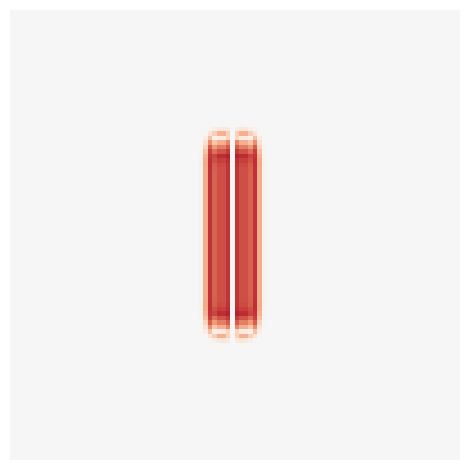

In [97]:
Utils.plot_rb(sol[end][:,:,1,1])

In [99]:
f.dx

100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [101]:
aa

100×100×1×1 view(::CuArray{Float32,4,Nothing}, :, :, 12:12, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    

In [105]:
f = LaminartGPU.LamFunction_007(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    aa, # dx
    aa, # dy
    aa, # dm
    aa, # dz
    aa, # ds
    aa, # dv_p
    aa, # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    );

In [106]:
prob = ODEProblem(f, u0, tspan, p)

ODEProblem with uType CuArray{Float32,4,Nothing} and tType Float32. In-place: true
timespan: (0.0f0, 5.0f0)
u0: Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

In [107]:
@benchmark sol = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  1.70 GiB
  allocs estimate:  35641071
  --------------
  minimum time:     28.783 s (2.06% GC)
  median time:      28.783 s (2.06% GC)
  mean time:        28.783 s (2.06% GC)
  maximum time:     28.783 s (2.06% GC)
  --------------
  samples:          1
  evals/sample:     1

In [108]:
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

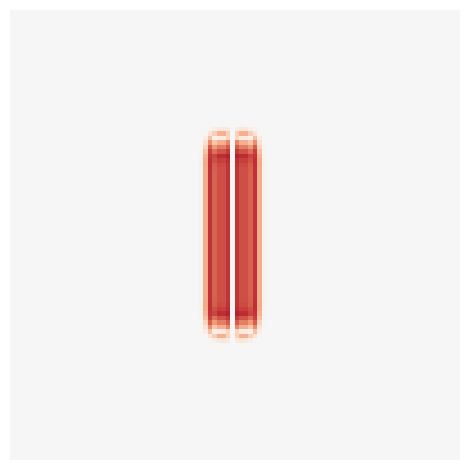

In [109]:
Utils.plot_rb(sol[end][:,:,1,1])

In [110]:
@benchmark sol = solve(prob, save_everystep=false)

BenchmarkTools.Trial: 
  memory estimate:  1.70 GiB
  allocs estimate:  35466029
  --------------
  minimum time:     28.632 s (1.84% GC)
  median time:      28.632 s (1.84% GC)
  mean time:        28.632 s (1.84% GC)
  maximum time:     28.632 s (1.84% GC)
  --------------
  samples:          1
  evals/sample:     1

In [121]:
du = similar(u0)
@code_warntype f(du, u0, p, 0f0)

Variables
  ff::MEngProject.LaminartGPU.LamFunction_007{CuArray{Float32,4,Nothing}}
  du::CuArray{Float32,4,Nothing}
  u::CuArray{Float32,4,Nothing}
  p::NamedTuple{(:K, :δ_v, :δ_c, :δ_m, :δ_z, :δ_s, :σ_1, :C_1, :C_2, :σ_2, :γ, :α, :ϕ, :Γ, :v_21, :μ, :ν, :n, :att, :η_p, :η_m, :λ, :a_23_ex, :a_23_in, :v12_6, :v12_4, :ψ, :C_AB_l, :H_σ_x, :H_σ_y, :H_fact, :H_l, :T_fact, :T_p_m, :T_v2_fact, :H_size, :W_size, :lgn_equ_u, :lgn_equ_A, :lgn_equ_B, :filling, :W_l, :k_gauss_1, :k_gauss_2, :k_C_A, :k_C_B, :k_x_lgn, :k_W_p, :k_W_m, :k_H, :k_T_p, :k_T_m, :k_T_p_v2, :k_T_m_v2, :dim_i, :dim_j, :x_V2, :ν_pw_n, :I, :r),Tuple{Int64,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Int64,Float32,Float32,Float32,Int64,Array{Float32,1},Float32,Float32,Int64,Int64,Float32,Float32,Float32,String,Int64,CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing

In [115]:
typeof(f.x)

CuArray{Float32,4,Nothing}

In [120]:
@code_warntype LaminartGPU.LamFunction_007(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    aa, # dx
    aa, # dy
    aa, # dm
    aa, # dz
    aa, # ds
    aa, # dv_p
    aa, # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    ); 

Variables
  #self#::Type{MEngProject.LaminartGPU.LamFunction_007}
  x::CuArray{Float32,4,Nothing}
  y::CuArray{Float32,4,Nothing}
  m::CuArray{Float32,4,Nothing}
  z::CuArray{Float32,4,Nothing}
  s::CuArray{Float32,4,Nothing}
  v_p::CuArray{Float32,4,Nothing}
  v_m::CuArray{Float32,4,Nothing}
  dx::SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}
  dy::SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}
  dm::SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}
  dz::SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}
  ds::SubArray

In [128]:
@time f(du, u0, p, 0f0)

  0.009286 seconds (6.72 k allocations: 804.625 KiB)


In [131]:
@time f(du, u0, p, 0f0)

  0.000002 seconds


In [135]:
du_ = similar(u0)
dx_ = @view du_[:, :, 1:p.K,:] 
dy_ = @view du_[:, :, p.K+1:2*p.K,:] 
dm_ = @view du_[:, :, 2*p.K+1:3*p.K,:] 
dz_ = @view du_[:, :, 3*p.K+1:4*p.K,:] 
ds_ = @view du_[:, :, 4*p.K+1:5*p.K,:] 

dv_p_ = @view du_[:, :, 5*p.K+1:5*p.K+1,:] 
dv_m_ = @view du_[:, :, 5*p.K+2:5*p.K+2,:] 

f = LaminartGPU.LamFunction_007(
    similar(arr1), # x
    similar(arr1), # y
    similar(arr1), # m
    similar(arr1), # z
    similar(arr1), # s
    similar(arr2), # v_p
    similar(arr2), # v_m
    dx_, # dx
    dy_, # dy
    dm_, # dm
    dz_, # dz
    ds_, # ds
    dv_p_, # dv_p
    dv_m_, # dv_m
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    ); 

In [136]:
f.dx

100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [138]:
@time f(du, u0, p, 0f0)

  0.009022 seconds (6.72 k allocations: 804.625 KiB)


In [139]:
ff = f

(::MEngProject.LaminartGPU.LamFunction_007{CuArray{Float32,4,Nothing}}) (generic function with 1 method)

In [142]:
@time ff.x .= CuArray(@view u[:, :, 1:p.K,:])

  0.000886 seconds (200 allocations: 86.953 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [143]:
@time ff.x .= CuArray(@view u[:, :, p.K+1:2*p.K,:])

  0.000965 seconds (221 allocations: 87.406 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 11.0  11.0  11.0  11.0  11.0  11.0  …  11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0  …  11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0  …  11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0 

In [147]:
@time ff.y .= CuArray(@view u[:, :, 5*p.K:5*p.K,:])

  0.004496 seconds (214 allocations: 48.219 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [148]:
@time @. ff.x = @view u[:, :, 1:p.K,:]

  0.056360 seconds (12.17 k allocations: 740.445 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [150]:
@time @. ff.x = @view u[:, :, 1:p.K,:]

  0.000400 seconds (103 allocations: 4.922 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [151]:
@time ff.dx = @view du[:, :, 1:p.K,:] 

  0.003570 seconds (126 allocations: 6.625 KiB)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [153]:
f = LaminartGPU.LamFunction008(
    similar(arr2), # x_lgn
    similar(arr1), # C
    similar(arr1), # H_z
    similar(arr2), # V_temp1
    similar(arr2), # V_temp2
    similar(arr1), # A_temp
    similar(arr1), # B_temp
    ); 

In [154]:
prob = ODEProblem(f, u0, tspan, p)

ODEProblem with uType CuArray{Float32,4,Nothing} and tType Float32. In-place: true
timespan: (0.0f0, 5.0f0)
u0: Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

In [167]:
# du = similar(u0)
@time f(du, u0, p, 0f0)


TaskFailedException: TaskFailedException:
InterruptException:
Stacktrace:
 [1] Array at ./boot.jl:405 [inlined]
 [2] getindex at ./array.jl:395 [inlined]
 [3] setindex! at /mnt/storage_1/users/cullinanen/.julia/packages/GPUArrays/4W5rW/src/host/indexing.jl:104 [inlined]
 [4] _setindex! at ./abstractarray.jl:1096 [inlined]
 [5] setindex! at ./abstractarray.jl:1073 [inlined]
 [6] im2col!(::CuArray{Float32,2,CuArray{Float32,3,Nothing}}, ::SubArray{Float32,4,Base.ReshapedArray{Float32,5,SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},Tuple{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64}}},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},Int64},false}, ::DenseConvDims{3,(19, 19, 1),2,2,(1, 1, 1),(9, 9, 9, 9, 0, 0),(1, 1, 1),true}) at /mnt/storage_1/users/cullinanen/.julia/packages/NNlib/sSn9M/src/impl/conv_im2col.jl:232
 [7] macro expansion at /mnt/storage_1/users/cullinanen/.julia/packages/NNlib/sSn9M/src/impl/conv_im2col.jl:53 [inlined]
 [8] (::NNlib.var"#430#threadsfor_fun#181"{CuArray{Float32,3,Nothing},Float32,Float32,CuArray{Float32,5,CuArray{Float32,4,Nothing}},Base.ReshapedArray{Float32,5,SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},Tuple{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64}}},CuArray{Float32,5,CuArray{Float32,4,CuArray{Float32,4,Nothing}}},DenseConvDims{3,(19, 19, 1),2,2,(1, 1, 1),(9, 9, 9, 9, 0, 0),(1, 1, 1),true},Int64,Int64,Int64,UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:61
 [9] (::NNlib.var"#430#threadsfor_fun#181"{CuArray{Float32,3,Nothing},Float32,Float32,CuArray{Float32,5,CuArray{Float32,4,Nothing}},Base.ReshapedArray{Float32,5,SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},Tuple{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64}}},CuArray{Float32,5,CuArray{Float32,4,CuArray{Float32,4,Nothing}}},DenseConvDims{3,(19, 19, 1),2,2,(1, 1, 1),(9, 9, 9, 9, 0, 0),(1, 1, 1),true},Int64,Int64,Int64,UnitRange{Int64}})() at ./threadingconstructs.jl:28

In [168]:
tt = @view du[:,:,1:2,:]

100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [169]:
ttt = @view tt[:,:,:,:]

100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [174]:
using Sherlogs
A = Sherlog64.(rand(1000,1000));
b = Sherlog64.(rand(1000));
x = A\b;
lb = get_logbook()





LogBook(UInt64[0x00000000000008d4, 0x000000000000021d, 0x0000000000000244, 0x00000000000001f9, 0x0000000000000216, 0x00000000000001e0, 0x00000000000001bf, 0x00000000000001ae, 0x000000000000018a, 0x00000000000001a7  …  0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000])

In [176]:
using Sherlogs, PyPlot, StatsBase, Printf

A = Sherlog64.(rand(1000,1000))
b = Sherlog64.(rand(1000))

# trigger logging of A,b
A .+ 0
b .+ 0
# lb0 = copy(return_logbook())

# LU decomposition
x = A\b
lb1 = copy(return_logbook())

H0 = entropy(lb/sum(lb),2)
H1 = entropy(lb/sum(lb),2)

## PLOT
H0s = @sprintf "%.2f" H0
H1s = @sprintf "%.2f" H1

f = [1/512,1/4,1,4,512,Inf,-1/512,-1/4,-1,-4,-512,-Inf]
fs = ["⅟512","¼","1","4","512","∞","-⅟512","-¼","-1","-4","-512","-∞"]
fi = Int.(reinterpret.(UInt16,Float16.(f)))

fig,ax = subplots(1,1,figsize=(8,3))

ax.plot(lb0/sum(lb0)*100,label="U(0,1), H=$H0s bit")
ax.plot(lb1/sum(lb1)*100,label="A\\b,      H=$H1s bit")
legend()
ax.set_title("Float16 bitpattern histogram",loc="left")
ax.set_ylabel("[%]")
ax.set_xticks(fi)
ax.set_xticklabels(fs)
ax.set_xlim(0,2^16)

tight_layout()
# savefig("figs/matrixsolve.png")
# close(fig)

UndefVarError: UndefVarError: return_logbook not defined